In [1]:
#Importar Librerias
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, auc
)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

In [2]:
#Cargar el dataset
main_path="drive/MyDrive/Dataset_MP"
name= "df_final.csv"
full_path=os.path.join(main_path,name)

In [3]:
df = pd.read_csv(full_path)

In [4]:
# CREAR MUESTRA REPRESENTATIVA
df_modelo, _ = train_test_split(df, train_size=500000, stratify=df['DELAYED'], random_state=42)

print("Tamaño de la muestra:", df_modelo.shape)
print("Proporción de clases:\n", df_modelo['DELAYED'].value_counts(normalize=True))

Tamaño de la muestra: (500000, 13)
Proporción de clases:
 DELAYED
0    0.81389
1    0.18611
Name: proportion, dtype: float64


In [5]:
#Entrenamiento
X = df_modelo.drop('DELAYED', axis=1)
y = df_modelo['DELAYED']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

colum_categorica = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
colum_numeric= ['MONTH', 'DAY', 'DAY_OF_WEEK', 'DISTANCE',
                'SCHEDULED_DEPARTURE_sin', 'SCHEDULED_DEPARTURE_cos',
                'SCHEDULED_ARRIVAL_sin', 'SCHEDULED_ARRIVAL_cos', 'SCHEDULED_TIME']

def get_preprocessor():
    # Random Forest puede trabajar con sparse matrices, pero mejor dense para evitar problemas
    return ColumnTransformer([
        ('num', StandardScaler(), colum_numeric),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), colum_categorica)
    ])

preprocessor = get_preprocessor()

In [6]:
# Parámetros para grid search (puedes ampliar)
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}

In [7]:
# Función para evaluación y visualización
def evaluar_modelo(modelo, X_test, y_test, nombre):
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:,1] if hasattr(modelo, "predict_proba") else None

    print(f"\nEvaluación: {nombre}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"Recall: {recall_score(y_test, y_pred):.3f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        print(f"AUC-ROC: {roc_auc:.3f}")

        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0,1], [0,1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Curva ROC - {nombre}')
        plt.legend(loc='lower right')
        plt.show()

    print('\nMatrix de confusión')
    print(confusion_matrix(y_test, y_pred))
    print('\nMatrix de confusión')
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión - {nombre}')
    plt.show()

    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores parámetros (sin balanceo): {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}

Evaluación: Random Forest - Sin Balanceo
Accuracy: 0.806
Precision: 0.413
Recall: 0.095
F1 Score: 0.155
AUC-ROC: 0.665


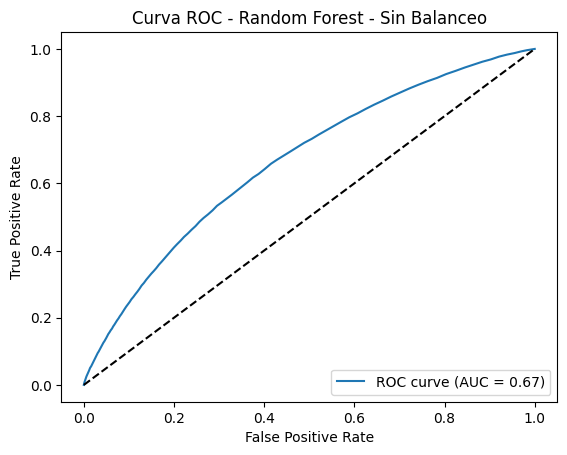


Matrix de confusión
[[98584  3152]
 [21045  2219]]

Matrix de confusión


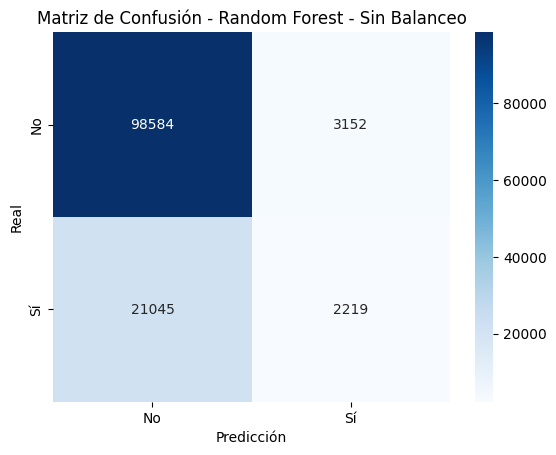


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89    101736
           1       0.41      0.10      0.15     23264

    accuracy                           0.81    125000
   macro avg       0.62      0.53      0.52    125000
weighted avg       0.75      0.81      0.75    125000



In [8]:
#Sin balanceo
pipeline_sin = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight=None))
])

grid_sin = GridSearchCV(pipeline_sin, param_grid=param_grid, scoring='f1', cv=3, n_jobs=-1)
grid_sin.fit(X_train, y_train)
print("Mejores parámetros (sin balanceo):", grid_sin.best_params_)
evaluar_modelo(grid_sin.best_estimator_, X_test, y_test, "Random Forest - Sin Balanceo")

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores parámetros (undersampling): {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}

Evaluación: Random Forest - UnderSampling
Accuracy: 0.607
Precision: 0.272
Recall: 0.664
F1 Score: 0.386
AUC-ROC: 0.679


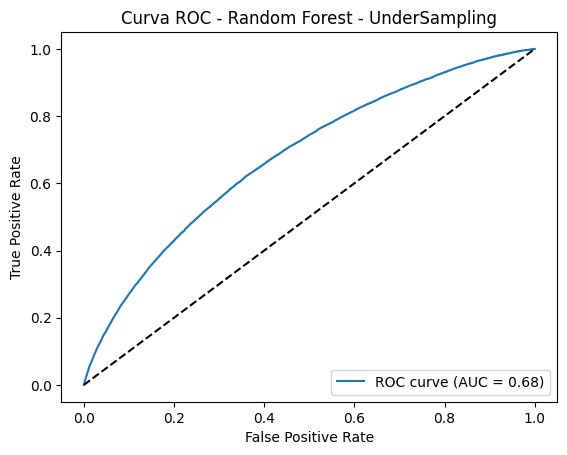


Matrix de confusión
[[60418 41318]
 [ 7816 15448]]

Matrix de confusión


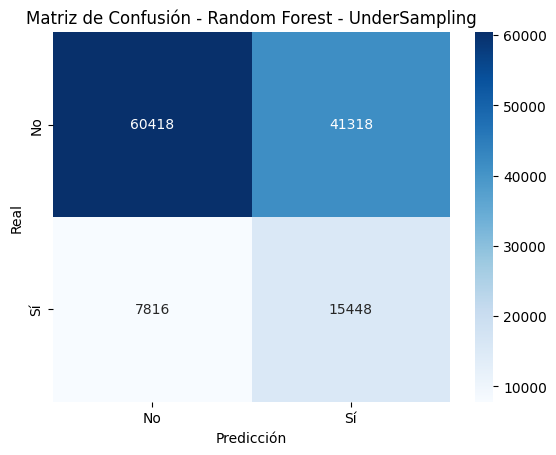


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.89      0.59      0.71    101736
           1       0.27      0.66      0.39     23264

    accuracy                           0.61    125000
   macro avg       0.58      0.63      0.55    125000
weighted avg       0.77      0.61      0.65    125000



In [9]:
#Con Random UnderSampling
pipeline_under = ImbPipeline([
    ('preprocessor', preprocessor),
    ('under', RandomUnderSampler(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42, class_weight=None))
])
grid_under = GridSearchCV(pipeline_under, param_grid=param_grid, scoring='f1', cv=3, n_jobs=-1)
grid_under.fit(X_train, y_train)
print("Mejores parámetros (undersampling):", grid_under.best_params_)
evaluar_modelo(grid_under.best_estimator_, X_test, y_test, "Random Forest - UnderSampling")

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores parámetros (SMOTE): {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}

Evaluación: Random Forest - SMOTE
Accuracy: 0.629
Precision: 0.267
Recall: 0.567
F1 Score: 0.363
AUC-ROC: 0.648


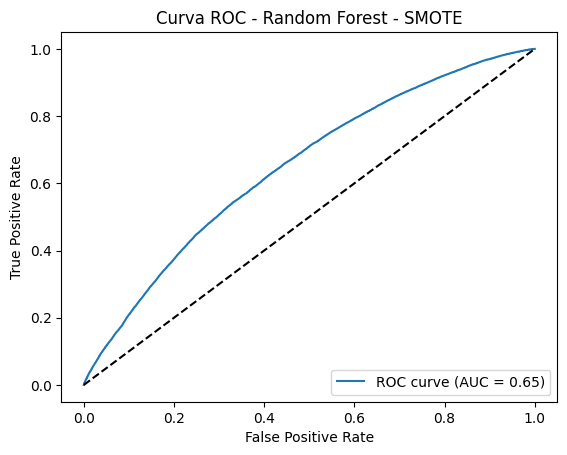


Matrix de confusión
[[65485 36251]
 [10069 13195]]

Matrix de confusión


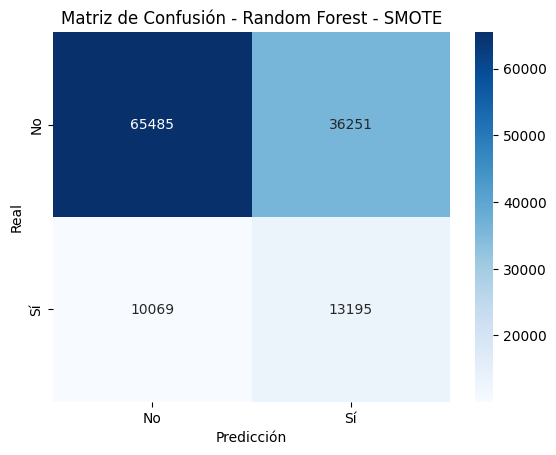


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.64      0.74    101736
           1       0.27      0.57      0.36     23264

    accuracy                           0.63    125000
   macro avg       0.57      0.61      0.55    125000
weighted avg       0.76      0.63      0.67    125000



In [10]:
#Con SMOTE
pipeline_smote = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42, class_weight=None))
])
grid_smote = GridSearchCV(pipeline_smote, param_grid=param_grid, scoring='f1', cv=3, n_jobs=-1)
grid_smote.fit(X_train, y_train)
print("Mejores parámetros (SMOTE):", grid_smote.best_params_)
evaluar_modelo(grid_smote.best_estimator_, X_test, y_test, "Random Forest - SMOTE")

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores parámetros (class_weight): {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

Evaluación: Random Forest - class_weight='balanced'
Accuracy: 0.595
Precision: 0.261
Recall: 0.642
F1 Score: 0.371
AUC-ROC: 0.657


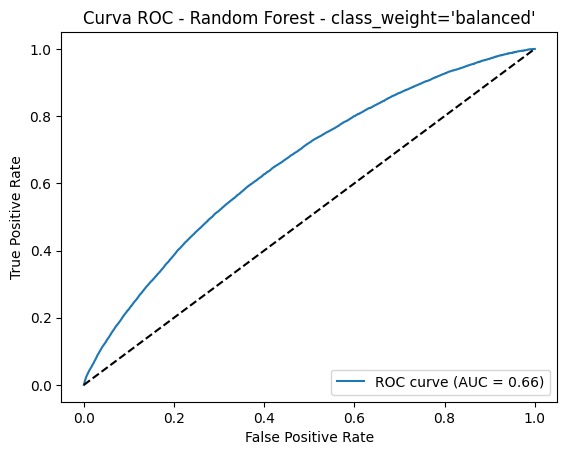


Matrix de confusión
[[59422 42314]
 [ 8326 14938]]

Matrix de confusión


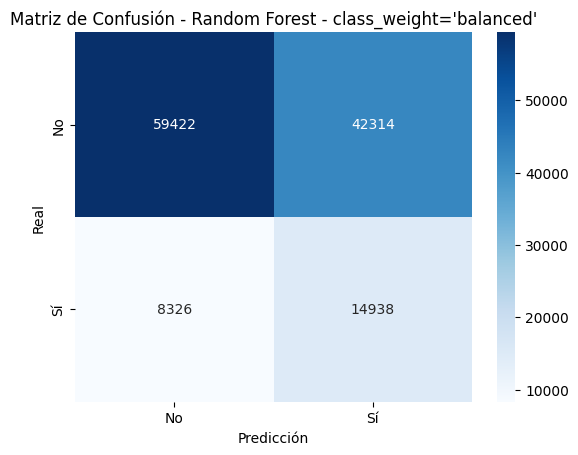


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.58      0.70    101736
           1       0.26      0.64      0.37     23264

    accuracy                           0.59    125000
   macro avg       0.57      0.61      0.54    125000
weighted avg       0.76      0.59      0.64    125000



In [11]:
#Con class_weight='balanced' interno
pipeline_class_weight = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])
grid_class_weight = GridSearchCV(pipeline_class_weight, param_grid=param_grid, scoring='f1', cv=3, n_jobs=-1)
grid_class_weight.fit(X_train, y_train)
print("Mejores parámetros (class_weight):", grid_class_weight.best_params_)
evaluar_modelo(grid_class_weight.best_estimator_, X_test, y_test, "Random Forest - class_weight='balanced'")

In [12]:
#Ejemplo siempre de prediccion

# Datos simulados de un nuevo vuelo
nuevo_vuelo = pd.DataFrame([{
    'MONTH': 7,
    'DAY': 22,
    'DAY_OF_WEEK': 1,
    'DISTANCE': 950,
    'SCHEDULED_DEPARTURE': 830,  # 08:30 am
    'SCHEDULED_ARRIVAL': 1045,   # 10:45 am
    'AIRLINE': 'AA',
    'ORIGIN_AIRPORT': 'JFK',
    'DESTINATION_AIRPORT': 'LAX'
}])

# Función para calcular duración del vuelo
def calcular_scheduled_time(dep, arr):
    dep = int(str(dep).zfill(4))
    arr = int(str(arr).zfill(4))
    dep_min = (dep // 100) * 60 + (dep % 100)
    arr_min = (arr // 100) * 60 + (arr % 100)
    if arr_min < dep_min:  # cruzan medianoche
        arr_min += 1440
    return arr_min - dep_min

# Calcular duración del vuelo
nuevo_vuelo['SCHEDULED_TIME'] = calcular_scheduled_time(
    nuevo_vuelo['SCHEDULED_DEPARTURE'].iloc[0],
    nuevo_vuelo['SCHEDULED_ARRIVAL'].iloc[0]
)

# Transformar hora a variables cíclicas
def transformar_hora(df, columna):
    df[columna] = df[columna].astype(str).str.zfill(4)
    minutos = df[columna].str[:2].astype(int) * 60 + df[columna].str[2:].astype(int)
    df[columna + '_sin'] = np.sin(2 * np.pi * minutos / 1440)
    df[columna + '_cos'] = np.cos(2 * np.pi * minutos / 1440)
    return df

# Aplicar transformación horaria
nuevo_vuelo = transformar_hora(nuevo_vuelo, 'SCHEDULED_DEPARTURE')
nuevo_vuelo = transformar_hora(nuevo_vuelo, 'SCHEDULED_ARRIVAL')

# Eliminar columnas no usadas por el modelo
nuevo_vuelo.drop(columns=['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL'], inplace=True)

# Selección del modelo entrenado

modelo_final = grid_under.best_estimator_


# Realizar predicción
prediccion = modelo_final.predict(nuevo_vuelo)
probabilidad = modelo_final.predict_proba(nuevo_vuelo)[:, 1]

# Mostrar resultados

print(f"¿Vuelo retrasado?: {'Sí' if prediccion[0] == 1 else 'No'}")
print(f"Probabilidad de retraso: {probabilidad[0]:.2f}")


¿Vuelo retrasado?: No
Probabilidad de retraso: 0.40
